# Pedro e o Lobo: Introdução ao Aprendizado por Reforço

Neste tutorial, vamos aprender como aplicar aprendizado por reforço a um problema de busca de caminhos. O cenário é inspirado no conto musical [Pedro e o Lobo](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) do compositor russo [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). É uma história sobre o jovem pioneiro Pedro, que corajosamente sai de casa para a clareira da floresta para perseguir o lobo. Vamos treinar algoritmos de aprendizado de máquina que ajudarão Pedro a explorar a área ao redor e construir um mapa de navegação ideal.

Primeiro, vamos importar algumas bibliotecas úteis:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Visão Geral do Aprendizado por Reforço

**Aprendizado por Reforço** (RL) é uma técnica de aprendizado que nos permite aprender o comportamento ideal de um **agente** em um determinado **ambiente** através da realização de muitos experimentos. Um agente nesse ambiente deve ter algum **objetivo**, definido por uma **função de recompensa**.

## O Ambiente

Para simplificar, vamos considerar o mundo de Peter como um tabuleiro quadrado de tamanho `width` x `height`. Cada célula nesse tabuleiro pode ser:
* **terra**, onde Peter e outras criaturas podem caminhar
* **água**, onde obviamente não se pode caminhar
* **uma árvore** ou **relva** - um lugar onde se pode descansar
* **uma maçã**, que representa algo que Peter ficaria feliz em encontrar para se alimentar
* **um lobo**, que é perigoso e deve ser evitado

Para trabalhar com o ambiente, vamos definir uma classe chamada `Board`. Para não sobrecarregar este notebook, movemos todo o código relacionado ao tabuleiro para um módulo separado chamado `rlboard`, que agora vamos importar. Você pode olhar dentro desse módulo para obter mais detalhes sobre os aspectos internos da implementação.


In [2]:
from rlboard import *

Vamos agora criar um tabuleiro aleatório e ver como fica:


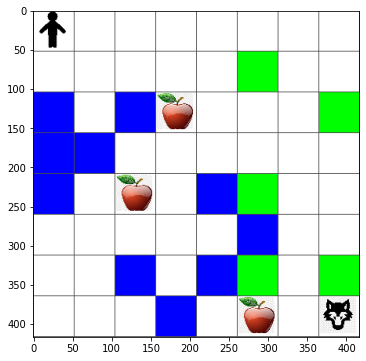

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Ações e Política

No nosso exemplo, o objetivo de Peter seria encontrar uma maçã, enquanto evita o lobo e outros obstáculos. Para isso, ele pode essencialmente andar até encontrar uma maçã. Assim, em qualquer posição, ele pode escolher entre uma das seguintes ações: cima, baixo, esquerda e direita. Vamos definir essas ações como um dicionário e mapeá-las para pares de alterações correspondentes nas coordenadas. Por exemplo, mover para a direita (`R`) corresponderia ao par `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

A estratégia do nosso agente (Peter) é definida por uma chamada **política**. Vamos considerar a política mais simples chamada **caminhada aleatória**.

## Caminhada aleatória

Vamos começar por resolver o nosso problema implementando uma estratégia de caminhada aleatória.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Vamos realizar a experiência de passeio aleatório várias vezes e ver o número médio de passos dados:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Função de Recompensa

Para tornar a nossa política mais inteligente, precisamos compreender quais movimentos são "melhores" do que outros.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Aprendizagem Q

Construa uma Q-Table, ou uma matriz multidimensional. Como o nosso tabuleiro tem dimensões `width` x `height`, podemos representar a Q-Table por um array numpy com a forma `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Passe a Q-Table para a função de plotagem para visualizar a tabela no tabuleiro:


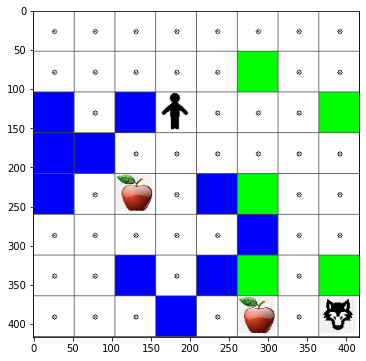

In [9]:
m.plot(Q)

## Essência do Q-Learning: Equação de Bellman e Algoritmo de Aprendizagem

Escreva um pseudo-código para o nosso algoritmo de aprendizagem:

* Inicializar a Tabela Q (Q-Table) com valores iguais para todos os estados e ações
* Definir a taxa de aprendizagem $\alpha\leftarrow 1$
* Repetir a simulação várias vezes
   1. Começar numa posição aleatória
   1. Repetir
        1. Selecionar uma ação $a$ no estado $s$
        2. Executar a ação movendo-se para um novo estado $s'$
        3. Se encontrarmos uma condição de fim de jogo ou se o total de recompensas for muito baixo - sair da simulação  
        4. Calcular a recompensa $r$ no novo estado
        5. Atualizar a Função Q de acordo com a equação de Bellman: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Atualizar a recompensa total e diminuir $\alpha$.

## Explorar vs. Explorar

A melhor abordagem é equilibrar entre exploração e exploração. À medida que aprendemos mais sobre o nosso ambiente, estaremos mais inclinados a seguir o caminho ótimo, no entanto, escolher o caminho inexplorado de vez em quando.

## Implementação em Python

Agora estamos prontos para implementar o algoritmo de aprendizagem. Antes disso, também precisamos de uma função que converta números arbitrários na Tabela Q (Q-Table) num vetor de probabilidades para as ações correspondentes:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Adicionamos uma pequena quantidade de `eps` ao vetor original para evitar divisão por 0 no caso inicial, quando todos os componentes do vetor são idênticos.

O algoritmo de aprendizagem que iremos executar durante 5000 experiências, também chamadas de **épocas**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Após executar este algoritmo, a Q-Table deverá ser atualizada com valores que definem a atratividade de diferentes ações em cada etapa. Visualize a tabela aqui:


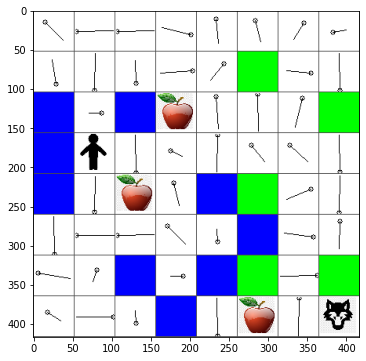

In [12]:
m.plot(Q)

## Verificar a Política

Como a Q-Table lista a "atratividade" de cada ação em cada estado, é bastante fácil utilizá-la para definir a navegação eficiente no nosso mundo. No caso mais simples, podemos simplesmente selecionar a ação correspondente ao valor mais alto na Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Se tentar o código acima várias vezes, pode notar que, por vezes, ele simplesmente "fica preso", e é necessário pressionar o botão STOP no notebook para interrompê-lo.

> **Tarefa 1:** Modifique a função `walk` para limitar o comprimento máximo do caminho a um certo número de passos (por exemplo, 100), e observe o código acima retornar este valor ocasionalmente.

> **Tarefa 2:** Modifique a função `walk` para que não volte aos locais onde já esteve anteriormente. Isto evitará que o `walk` entre em ciclos, no entanto, o agente ainda pode acabar "encurralado" num local do qual não consegue escapar.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


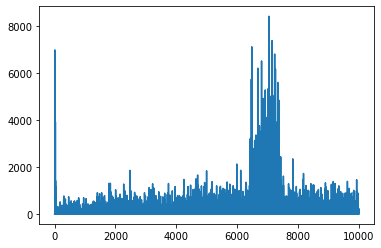

In [15]:
plt.plot(lpath)

O que observamos aqui é que, inicialmente, o comprimento médio do percurso aumentou. Isto provavelmente deve-se ao facto de, quando não sabemos nada sobre o ambiente, é mais provável que fiquemos presos em estados desfavoráveis, como água ou lobos. À medida que aprendemos mais e começamos a usar esse conhecimento, conseguimos explorar o ambiente por mais tempo, mas ainda não sabemos bem onde estão as maçãs.

Quando aprendemos o suficiente, torna-se mais fácil para o agente alcançar o objetivo, e o comprimento do percurso começa a diminuir. No entanto, ainda estamos abertos à exploração, o que significa que frequentemente nos desviamos do melhor caminho e exploramos novas opções, tornando o percurso mais longo do que o ideal.

O que também observamos neste gráfico é que, em determinado momento, o comprimento aumentou abruptamente. Isto indica a natureza estocástica do processo e que, em algum momento, podemos "estragar" os coeficientes da Q-Table ao substituí-los por novos valores. Idealmente, isto deve ser minimizado ao reduzir a taxa de aprendizagem (ou seja, no final do treino ajustamos os valores da Q-Table apenas por um valor pequeno).

De forma geral, é importante lembrar que o sucesso e a qualidade do processo de aprendizagem dependem significativamente de parâmetros como a taxa de aprendizagem, a redução da taxa de aprendizagem e o fator de desconto. Estes são frequentemente chamados de **hiperparâmetros**, para distingui-los dos **parâmetros** que otimizamos durante o treino (por exemplo, os coeficientes da Q-Table). O processo de encontrar os melhores valores para os hiperparâmetros é chamado de **otimização de hiperparâmetros**, e merece um tópico à parte.


## Exercício
#### Um Mundo Mais Realista de Pedro e o Lobo

Na nossa situação, Pedro conseguia deslocar-se quase sem se cansar ou sentir fome. Num mundo mais realista, ele precisa de se sentar e descansar de vez em quando, além de se alimentar. Vamos tornar o nosso mundo mais realista implementando as seguintes regras:

1. Ao mover-se de um lugar para outro, Pedro perde **energia** e ganha alguma **fadiga**.
2. Pedro pode ganhar mais energia ao comer maçãs.
3. Pedro pode livrar-se da fadiga descansando debaixo da árvore ou na relva (ou seja, ao caminhar para uma localização no tabuleiro com uma árvore ou relva - campo verde).
4. Pedro precisa encontrar e matar o lobo.
5. Para matar o lobo, Pedro precisa ter certos níveis de energia e fadiga, caso contrário, perde a batalha.

Modifique a função de recompensa acima de acordo com as regras do jogo, execute o algoritmo de aprendizagem por reforço para aprender a melhor estratégia para vencer o jogo e compare os resultados da caminhada aleatória com o seu algoritmo em termos de número de jogos ganhos e perdidos.

> **Note**: Pode ser necessário ajustar os hiperparâmetros para que funcione, especialmente o número de épocas. Como o sucesso do jogo (lutar contra o lobo) é um evento raro, pode esperar um tempo de treino muito mais longo.



---

**Aviso Legal**:  
Este documento foi traduzido utilizando o serviço de tradução por IA [Co-op Translator](https://github.com/Azure/co-op-translator). Embora nos esforcemos para garantir a precisão, é importante notar que traduções automáticas podem conter erros ou imprecisões. O documento original na sua língua nativa deve ser considerado a fonte autoritária. Para informações críticas, recomenda-se a tradução profissional realizada por humanos. Não nos responsabilizamos por quaisquer mal-entendidos ou interpretações incorretas decorrentes da utilização desta tradução.
